# 作業：註解 Transformer Decoder Layer
***
## [作業目標]
- 仔細地瞭解 Transformer 重要元件的建構方法

## [作業重點]
- 觀察並且註解 Decoder Layer 的實作方式
- 觀察並且註解標準的 Decoder 三層結構的實作方式
    - Masked Multi-Head Attention
    - Encoder-Decoder Attention
    - Position-Wise Feedforward
- 觀察並且註解沒有 Encoder-Decoder Attention 的 Decoder 兩層結構的實作方式

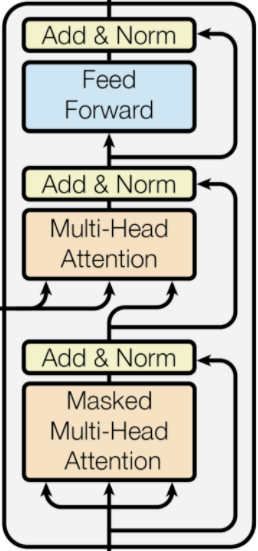

In [ ]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, hidden_dim, feedforward_dim, n_dec_layers, n_attn_heads, dropout, device, skip_encoder_attn=False):
        super(TransformerDecoderLayer, self).__init__()
        self.skip_encoder_attn = skip_encoder_attn 

        # 建立 Masked Multi-Head Attention
        self.self_attention_sublayer = MultiHeadAttentionSubLayer(hidden_dim, n_attn_heads, dropout, device)
        self.self_attn_layernorm = nn.LayerNorm(hidden_dim)

        # 建立 Encoder-Decoder Multi-Head Attention
        if not skip_encoder_attn:
            self.encoder_attention_sublayer = MultiHeadAttentionSubLayer(hidden_dim, n_attn_heads, dropout, device)
            self.encoder_attn_layernorm = nn.LayerNorm(hidden_dim)

        # 建立 Position-Wise Feedforward
        self.positionwise_feedforward = PosFeedForwardSubLayer(hidden_dim, feedforward_dim, dropout)
        self.feedforward_layernorm = nn.LayerNorm(hidden_dim)
    
        self.dropout = nn.Dropout(dropout)

    def forward(self, dec_seq, enc_hidden, dec_mask, enc_mask):
        '''
            dec_seq: [batch_size, decode_sequence_len, hid_dim]
            enc_hidden: [batch_size, encode_sequence_len, hid_dim]  # Optional
            dec_mask: [batch_size, decode_sequence_len]
            enc_mask: [batch_size, encode_sequence_len]  # Optional
        '''

        # first Multi-Head Attention layer
        _dec_seq, decoder_self_attention = self.self_attention_sublayer(dec_seq, dec_seq, dec_seq, dec_mask)
        # dropout, residual connection and layer norm(Add and Norm)
        dec_seq = self.self_attn_layernorm(dec_seq + self.dropout(_dec_seq))  # (batch_size, decode_sequence_len, hid_dim)

        # second Encoder-Decoder Multi-Head Attention layer
        if not self.skip_encoder_attn:
            # Encoder Attention
            _dec_seq, encoder_decoder_attention = self.encoder_attention_sublayer(dec_seq, enc_hidden, enc_hidden, enc_mask)
              # dropout, residual connection and layer norm(Add and Norm)
            dec_seq = self.encoder_attn_layernorm(dec_seq + self.dropout(_dec_seq))
            # dec_seq: [batch_size, decode_sequence_len, hid_dim]
        else:
            encoder_decoder_attention = None

        # third Position-Wise Feedforward
        _dec_seq = self.positionwise_feedforward(dec_seq)
        # dropout, residual and layer norm(Add and Norm)
        dec_seq = self.feedforward_layernorm(dec_seq + self.dropout(_dec_seq))  # (batch_size, decode_sequence_len, hid_dim)
        
        return dec_seq, encoder_decoder_attention , decoder_self_attention